In [1]:
#CW
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()


(1, 3, 224, 224)


In [3]:
#adam的最大迭代次数 论文中建议10000次 测试阶段1000也可以 1000次可以完成95%的优化工作
max_iterations=1000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1
confidence=initial_const

#k值
k=40

#像素值区间
boxmin = -3.0
boxmax = 3.0

#类别数 pytorch的实现里面是1000
num_labels=1000

#攻击目标标签 必须使用one hot编码
target_label=288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())


print()

shape = (1,3,224,224)


In [4]:


#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]



In [5]:
import torch.nn.functional as F

# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    
    #把原始图像转换成图像数据和扰动的形态
    timg = Variable(torch.from_numpy(np.arctanh((img - boxplus) / boxmul * 0.999999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    

    #设置为不保存梯度值 自然也无法修改
    #for param in model.parameters():
    #    param.requires_grad = False
        
    #图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    

    #定义优化器 仅优化modifier
    optimizer = torch.optim.Adam([modifier],lr=learning_rate)
    
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        
        #定义新输入
        newimg = torch.tanh(modifier + timg) * boxmul + boxplus
      
        output=model(newimg)
             
        #定义cw中的损失函数
        
        #l2范数
        #l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * boxmul + boxplus)),[1,2,3])
        #loss2 = tf.reduce_sum(l2dist)
        loss2=torch.dist(newimg,(torch.tanh(timg) * boxmul + boxplus),p=2)
        
        """
        # compute the probability of the label class versus the maximum other
            real = tf.reduce_sum((tlab)*output,1)
            # 论文中的开源实现 other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)
            other = tf.reduce_max((1-tlab)*output)
            loss1 = tf.maximum(0.0, other-real+k)
            loss1 = tf.reduce_sum(const*loss1)
        """
               
        real=torch.max(output*tlab)
        other=torch.max((1-tlab)*output)  
        loss1=other-real+k   
        loss1=torch.clamp(loss1,min=0)
             
        loss1=confidence*loss1
           
        loss=loss1+loss2
               
        loss.backward(retain_graph=True)

        optimizer.step()
              
        l2=loss2
        
        sc=output.data.cpu().numpy()
        
        
        #输出的是概率
        pro=F.softmax(model(newimg),dim=1)[0].data.cpu().numpy()[target_label]
         
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print("iteration={} loss={} loss1={} loss2={} pro={}".format(iteration,loss,loss1,loss2,pro))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) and ( pro > 0.8  ):
        #if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) :
            print("attack success l2={} target_label={} pro={}".format(l2,target_label,pro))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = newimg.data.cpu().numpy()
            
    confidence_old=-1       
    if (o_bestscore == target_label) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=1
attack success l2=12.031506538391113 target_label=288 pro=0.814875602722168
iteration=100 loss=45.23546600341797 loss1=32.341468811035156 loss2=12.893998146057129 pro=0.9988723397254944
iteration=200 loss=44.405555725097656 loss1=31.594274520874023 loss2=12.811281204223633 pro=0.9991834759712219
iteration=300 loss=44.283199310302734 loss1=31.184581756591797 loss2=13.098616600036621 pro=0.9995487332344055
iteration=400 loss=43.743099212646484 loss1=30.08397102355957 loss2=13.659127235412598 pro=0.9996814727783203
iteration=500 loss=43.01424789428711 loss1=30.025135040283203 loss2=12.989113807678223 pro=0.9997749924659729
iteration=600 loss=43.524864196777344 loss1=30.360523223876953 loss2=13.164342880249023 pro=0.9997320771217346
iteration=700 loss=43.220821380615234 loss1=29.99690818786621 loss2=13.223913192749023 pro=0.9997766613960266
iteration=800 loss=43.944175720214844 loss1=30.076265335083008 loss2=13.867908477783203 pro=0.9997839331626892
iter

iteration=500 loss=1.0323837995529175 loss1=0.8183119297027588 loss2=0.21407188475131989 pro=3.881280917994445e-06
iteration=600 loss=1.0857763290405273 loss1=0.8243181705474854 loss2=0.261458158493042 pro=2.685242179722991e-06
iteration=700 loss=1.0465281009674072 loss1=0.8228265643119812 loss2=0.22370147705078125 pro=2.9457332857418805e-06
iteration=800 loss=1.1199527978897095 loss1=0.818406879901886 loss2=0.3015458881855011 pro=3.877406925312243e-06
iteration=900 loss=1.1548526287078857 loss1=0.818581223487854 loss2=0.33627140522003174 pro=3.833224582194816e-06
iteration=1000 loss=1.0963170528411865 loss1=0.8231522440910339 loss2=0.2731648087501526 pro=2.8978897717024665e-06

outer_step=6 confidence 0.015625->0.0078125
o_bestl2=6.399918556213379 confidence=0.0078125
iteration=100 loss=0.7181757688522339 loss1=0.41044771671295166 loss2=0.30772802233695984 pro=3.3225046536244918e-06
iteration=200 loss=0.7456233501434326 loss1=0.40996572375297546 loss2=0.33565765619277954 pro=3.5200951

In [6]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


In [7]:
adv=o_bestattack[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


(3, 224, 224)


In [8]:
def infer_img(img,t=0):
    import torch.nn.functional as F
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
      
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    return pro

In [9]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))
print(infer_img(adv))
print(infer_img(adv,t=288))
print(infer_img(adv,t=388))

0.9270878
3.1756701e-06
0.9270878
0.82362115
0.82362115
0.004630537


std=-200 adv_pro[388]=0.0003151316777803004 original_pro[388]=0.00024459193809889257
std=-190 adv_pro[388]=0.0004486938414629549 original_pro[388]=0.00039375823689624667
std=-180 adv_pro[388]=0.0009131740080192685 original_pro[388]=0.0007047083927318454
std=-170 adv_pro[388]=0.0016526312101632357 original_pro[388]=0.001618988811969757
std=-160 adv_pro[388]=0.004813466686755419 original_pro[388]=0.006405696272850037
std=-150 adv_pro[388]=0.018884291872382164 original_pro[388]=0.027706636115908623
std=-140 adv_pro[388]=0.06116841360926628 original_pro[388]=0.12104601413011551
std=-130 adv_pro[388]=0.1991758942604065 original_pro[388]=0.350337952375412
std=-120 adv_pro[388]=0.5023497343063354 original_pro[388]=0.599442183971405
std=-110 adv_pro[388]=0.6621582508087158 original_pro[388]=0.7255505323410034
std=-100 adv_pro[388]=0.7218574285507202 original_pro[388]=0.7963696718215942
std=-90 adv_pro[388]=0.8321499228477478 original_pro[388]=0.8710362911224365
std=-80 adv_pro[388]=0.902614712

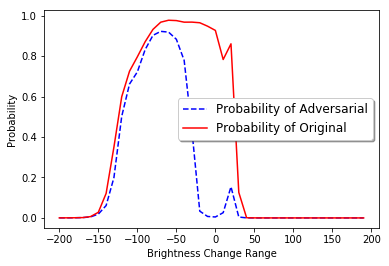

In [10]:
import matplotlib.pyplot as plt
#综合分析亮度对 对抗样本和正常图片分类的影响
std_range = range(-200,200,10)
original_pro = []
adv_pro = []

for i in std_range:
    
    brightness_adv_img=np.clip((adv.copy()+i),0,255)
    
    pro_388=infer_img(brightness_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    brightness_img=np.clip((orig.copy()+i),0,255)
    pro=infer_img(brightness_img.copy(),388)
    original_pro += [pro]
            
    print("std={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Brightness Change Range')
plt.ylabel('Probability')
plt.show()

std=-200 pro[388]=0.0003151316777803004 pro[288]=0.0005137441330589354
std=-190 pro[388]=0.0004486938414629549 pro[288]=0.0008063855930231512
std=-180 pro[388]=0.0009131740080192685 pro[288]=0.0008298102766275406
std=-170 pro[388]=0.0016526312101632357 pro[288]=0.000696393777616322
std=-160 pro[388]=0.004813466686755419 pro[288]=0.0006781294359825552
std=-150 pro[388]=0.018884291872382164 pro[288]=0.000925946980714798
std=-140 pro[388]=0.06116841360926628 pro[288]=0.0008791953441686928
std=-130 pro[388]=0.1991758942604065 pro[288]=0.0007791933021508157
std=-120 pro[388]=0.5023497343063354 pro[288]=0.0005825222469866276
std=-110 pro[388]=0.6621582508087158 pro[288]=0.0004460686759557575
std=-100 pro[388]=0.7218574285507202 pro[288]=0.0003651744918897748
std=-90 pro[388]=0.8321499228477478 pro[288]=0.00027571196551434696
std=-80 pro[388]=0.9026147127151489 pro[288]=0.00028912577545270324
std=-70 pro[388]=0.9224019050598145 pro[288]=0.000397253519622609
std=-60 pro[388]=0.9187487363815308

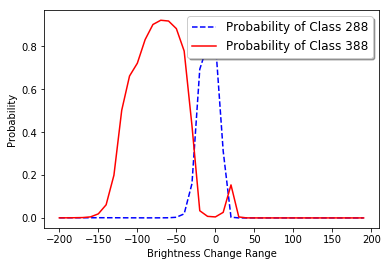

In [12]:
#验证亮度对  对抗样本的影响
std_range = range(-200,200,10)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    brightness_adv_img=np.clip((adv.copy()+i),0,255)
    
    pro_388=infer_img(brightness_adv_img.copy(),388)
    pro_288=infer_img(brightness_adv_img.copy(),288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Brightness Change Range')
plt.ylabel('Probability')
plt.show()

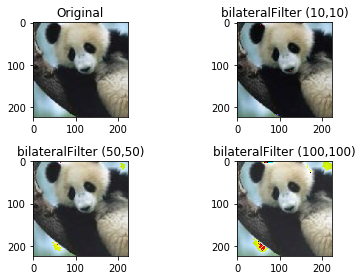

In [16]:
#展示亮度的效果
def show_brightness():
    img2=np.clip((orig.copy()-10),0,255)
    img3=np.clip((orig.copy()+10),0,255)
    img4=np.clip((orig.copy()+20),0,255)


    plt.subplot(221)
    plt.imshow(orig,cmap=plt.cm.gray) 
    plt.title("Original")

    plt.subplot(222)
    plt.imshow(img2,cmap=plt.cm.gray) 
    plt.title("bilateralFilter (10,10)")

    plt.subplot(223)
    plt.imshow(img3,cmap=plt.cm.gray) 
    plt.title("bilateralFilter (50,50)")

    plt.subplot(224)
    plt.imshow(img4,cmap=plt.cm.gray) 
    plt.title("bilateralFilter (100,100)")

    plt.tight_layout()


show_brightness()

std=0.1 pro[388]=0.0006955194403417408 pro[288]=0.0003473238321021199
std=0.2 pro[388]=0.14837825298309326 pro[288]=0.0002604679320938885
std=0.30000000000000004 pro[388]=0.42645370960235596 pro[288]=0.00020237006538081914
std=0.4 pro[388]=0.47505393624305725 pro[288]=0.0006037072744220495
std=0.5 pro[388]=0.49450185894966125 pro[288]=0.004393122158944607
std=0.6 pro[388]=0.373485267162323 pro[288]=0.0381070114672184
std=0.7000000000000001 pro[388]=0.1707734316587448 pro[288]=0.23380793631076813
std=0.8 pro[388]=0.042343512177467346 pro[288]=0.5771459341049194
std=0.9 pro[388]=0.011401454918086529 pro[288]=0.7572875022888184
std=1.0 pro[388]=0.004630536772310734 pro[288]=0.8236211538314819
std=1.1 pro[388]=0.005694476887583733 pro[288]=0.8091995120048523
std=1.2000000000000002 pro[388]=0.015955552458763123 pro[288]=0.7074995636940002
std=1.3000000000000003 pro[388]=0.09964470565319061 pro[288]=0.3431576192378998
std=1.4000000000000001 pro[388]=0.2240234613418579 pro[288]=0.097768411040

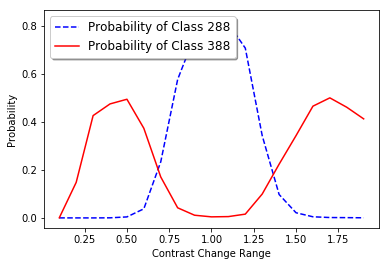

In [20]:
#验证对比度对  对抗样本的影响
std_range = np.arange(0.1,2.0,0.1)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    contrast_adv_img=np.clip((adv.copy()*i),0,255)
    
    pro_388=infer_img(contrast_adv_img.copy(),388)
    pro_288=infer_img(contrast_adv_img.copy(),288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Contrast Change Range')
plt.ylabel('Probability')
plt.show()

std=0.1 adv_pro[388]=0.0006955194403417408 original_pro[388]=0.0009544233907945454
std=0.2 adv_pro[388]=0.14837825298309326 original_pro[388]=0.27156227827072144
std=0.30000000000000004 adv_pro[388]=0.42645370960235596 original_pro[388]=0.7445499897003174
std=0.4 adv_pro[388]=0.47505393624305725 original_pro[388]=0.8827868700027466
std=0.5 adv_pro[388]=0.49450185894966125 original_pro[388]=0.9346916675567627
std=0.6 adv_pro[388]=0.373485267162323 original_pro[388]=0.94096839427948
std=0.7000000000000001 adv_pro[388]=0.1707734316587448 original_pro[388]=0.941083550453186
std=0.8 adv_pro[388]=0.042343512177467346 original_pro[388]=0.9402674436569214
std=0.9 adv_pro[388]=0.011401454918086529 original_pro[388]=0.9354694485664368
std=1.0 adv_pro[388]=0.004630536772310734 original_pro[388]=0.9270877838134766
std=1.1 adv_pro[388]=0.005694476887583733 original_pro[388]=0.938504159450531
std=1.2000000000000002 adv_pro[388]=0.015955552458763123 original_pro[388]=0.9616803526878357
std=1.30000000

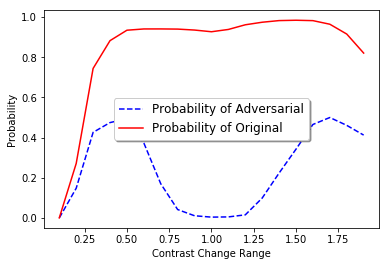

In [21]:
import matplotlib.pyplot as plt
#综合分析对比度对 对抗样本和正常图片分类的影响
std_range = np.arange(0.1,2.0,0.1)
original_pro = []
adv_pro = []

for i in std_range:
    
    contrast_adv_img=np.clip((adv.copy()*i),0,255)
    
    pro_388=infer_img(contrast_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    contrast_img=np.clip((orig.copy()*i),0,255)
    pro=infer_img(contrast_img.copy(),388)
    original_pro += [pro]
            
    print("std={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Contrast Change Range')
plt.ylabel('Probability')
plt.show()